In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

### Step 1 — Import the date

In [2]:
# Time series models are index-driven, not column-driven
df = pd.read_csv(
    "traffic_volume_cleaned_hourly.csv",
    parse_dates=["date_time"],
    index_col="date_time"
)

df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday,weather_main,weather_description
date_time,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,NaN,Clouds,scattered clouds
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,NaN,Clouds,broken clouds
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,NaN,Clouds,overcast clouds
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,NaN,Clouds,overcast clouds
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,NaN,Clouds,broken clouds


In [3]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 52551 non-null  float64
 1   rain_1h              52551 non-null  float64
 2   snow_1h              52551 non-null  float64
 3   clouds_all           52551 non-null  float64
 4   traffic_volume       52551 non-null  float64
 5   holiday              56 non-null     object 
 6   weather_main         52551 non-null  object 
 7   weather_description  52551 non-null  object 
dtypes: float64(5), object(3)
memory usage: 3.6+ MB


### Step 2 — Define the target variable (y)

In [5]:
y = df["traffic_volume"]

In [6]:
# Verify y is correct (mandatory check)
type(y)

pandas.core.series.Series

In [7]:
y.head()

date_time
2012-10-02 09:00:00    5545.0
2012-10-02 10:00:00    4516.0
2012-10-02 11:00:00    4767.0
2012-10-02 12:00:00    5026.0
2012-10-02 13:00:00    4918.0
Name: traffic_volume, dtype: float64

In [8]:
y.index.equals(df.index)

True

### Step 3 — Conceptual Definition of Exogenous Variables (X)

In this step, identify which external variables will be used in the SARIMAX model.
Based on EDA, weather and holiday variables are considered meaningful exogenous drivers
of traffic volume.

Based on exploratory data analysis, the following variables are selected as
exogenous inputs for the SARIMAX model:

**Numeric weather variables**
- temp
- rain_1h
- snow_1h
- clouds_all

**Categorical variables**
- holiday
- weather_main

The variable `weather_description` is excluded due to high granularity and
redundancy with `weather_main`.

## Step 4 – Create Exogenous Matrix (X)

In this step, construct the exogenous variable matrix (X) to be used
later in the SARIMAX model. These variables are external drivers of traffic
volume and are assumed to be known in advance.

Exogenous variables are not used in the baseline or SARIMA models.

In [9]:
# Select raw exogenous variablesexog_raw = df[
exog_raw = df[
    [
        "temp",
        "rain_1h",
        "snow_1h",
        "clouds_all",
        "holiday",
        "weather_main"
    ]
]

exog_raw.head()

,temp,rain_1h,snow_1h,clouds_all,holiday,weather_main
date_time,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,NaN,Clouds
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,NaN,Clouds
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,NaN,Clouds
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,NaN,Clouds
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,NaN,Clouds


Categorical exogenous variables must be converted into numerical form
before being used in a SARIMAX model. This is done using one-hot encoding.

To avoid multicollinearity, the first category of each variable is dropped.

In [10]:
# One-hot encode categorical variables
X = pd.get_dummies(
    exog_raw,
    columns=["holiday", "weather_main"],
    drop_first=True
)

X.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temp                               52551 non-null  float64
 1   rain_1h                            52551 non-null  float64
 2   snow_1h                            52551 non-null  float64
 3   clouds_all                         52551 non-null  float64
 4   holiday_Columbus Day               52551 non-null  bool   
 5   holiday_Independence Day           52551 non-null  bool   
 6   holiday_Labor Day                  52551 non-null  bool   
 7   holiday_Martin Luther King Jr Day  52551 non-null  bool   
 8   holiday_Memorial Day               52551 non-null  bool   
 9   holiday_New Years Day              52551 non-null  bool   
 10  holiday_State Fair                 52551 non-null  bool   
 11  holiday_Thanksgivin

The exogenous matrix X has been successfully created by selecting relevant
weather and holiday variables and encoding categorical features using
one-hot encoding.

The resulting matrix is fully numeric, time-aligned with the target variable,
and ready for time-based train/test splitting.

## Step 5 – Time-Based Train / Test Split

Time series data must be split chronologically to avoid data leakage.
Random splitting is not appropriate because future information would
become available to the model during training.

In this project, earlier observations are used for training and later
observations are reserved for testing.

The dataset spans from October 2012 to September 2018.
Data before 2018 is used for training, and data from 2018 onward is used
as the test set.

In [12]:
# Define split date
split_date = "2018-01-01"

In [13]:
# Split target variable y
y_train = y.loc[y.index < split_date]
y_test  = y.loc[y.index >= split_date]

y_train.head(), y_test.head()

(date_time
 2012-10-02 09:00:00    5545.0
 2012-10-02 10:00:00    4516.0
 2012-10-02 11:00:00    4767.0
 2012-10-02 12:00:00    5026.0
 2012-10-02 13:00:00    4918.0
 Name: traffic_volume, dtype: float64,
 date_time
 2018-01-01 00:00:00    1478.0
 2018-01-01 01:00:00    1408.0
 2018-01-01 02:00:00     931.0
 2018-01-01 03:00:00     585.0
 2018-01-01 04:00:00     381.0
 Name: traffic_volume, dtype: float64)

In [14]:
# Split exogenous variables X
X_train = X.loc[X.index < split_date]
X_test  = X.loc[X.index >= split_date]

X_train.head(3), X_test.head(3)

(                       temp  rain_1h  snow_1h  clouds_all  \
 date_time                                                   
 2012-10-02 09:00:00  288.28      0.0      0.0        40.0   
 2012-10-02 10:00:00  289.36      0.0      0.0        75.0   
 2012-10-02 11:00:00  289.58      0.0      0.0        90.0   
 
                      holiday_Columbus Day  holiday_Independence Day  \
 date_time                                                             
 2012-10-02 09:00:00                 False                     False   
 2012-10-02 10:00:00                 False                     False   
 2012-10-02 11:00:00                 False                     False   
 
                      holiday_Labor Day  holiday_Martin Luther King Jr Day  \
 date_time                                                                   
 2012-10-02 09:00:00              False                              False   
 2012-10-02 10:00:00              False                              False   
 2012-10-02 11

In [15]:
# Alignment checks
assert y_train.index.equals(X_train.index)
assert y_test.index.equals(X_test.index)

print("Train period:", y_train.index.min(), "to", y_train.index.max())
print("Test period:", y_test.index.min(), "to", y_test.index.max())

print("Train size:", len(y_train))
print("Test size:", len(y_test))

Train period: 2012-10-02 09:00:00 to 2017-12-31 23:00:00
Test period: 2018-01-01 00:00:00 to 2018-09-30 23:00:00
Train size: 45999
Test size: 6552


The dataset has been split into training and test sets using a
time-based approach. Both the target variable and exogenous variables
remain perfectly aligned in time, ensuring no data leakage.

The data is now ready for baseline, SARIMA, and SARIMAX modeling.

## Step 6 – Baseline Seasonal Model

As a benchmark, a seasonal naive baseline model is used.
The forecast at each time step is defined as the observed value
from the same hour in the previous week.

This baseline captures strong daily and weekly seasonality
without any parameter estimation.

In [16]:
# Define seasonal period
SEASONAL_PERIOD = 168  # 24 hours * 7 days

In [17]:
# Seasonal naive baseline: use last week's value
y_baseline_pred = y_test.copy()

y_baseline_pred = y.shift(SEASONAL_PERIOD).loc[y_test.index]

y_baseline_pred.head()

date_time
2018-01-01 00:00:00    1092.0
2018-01-01 01:00:00     666.0
2018-01-01 02:00:00     487.0
2018-01-01 03:00:00     349.0
2018-01-01 04:00:00     339.0
Name: traffic_volume, dtype: float64

In [18]:
# Check for missing predictions
y_baseline_pred.isna().sum()

np.int64(0)

In [19]:
# Mask included for general safety; no NaNs present in this dataset
baseline_mask = ~y_baseline_pred.isna()

In [20]:
# Evaluate baseline performance (no missing predictions in this case)
baseline_mse = mean_squared_error(
    y_test[baseline_mask],
    y_baseline_pred[baseline_mask]
)

baseline_rmse = np.sqrt(baseline_mse)

baseline_rmse

np.float64(645.6405587279048)

The seasonal naive model provides a baseline performance level.
All subsequent models (SARIMA and SARIMAX) must outperform this
baseline to justify additional complexity.

## Step 7.1.1 – SARIMA (No Exogenous Variables)

This step evaluates a SARIMA model that uses only historical traffic
volume to capture temporal dependence. No exogenous variables are
included at this stage.

The goal is to assess how much predictive power can be obtained from
past traffic values alone, beyond the seasonal naïve baseline.

In [21]:
# SARIMA without exogenous variables or seasonal state space
sarima_model = SARIMAX(
    y_train,
    order=(1, 0, 0),          # simple AR structure
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)

sarima_results.summary()

C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                45999
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -372024.468
Date:                Thu, 01 Jan 2026   AIC                         744052.936
Time:                        23:30:10   BIC                         744070.409
Sample:                    10-02-2012   HQIC                        744058.431
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9747      0.001    927.247      0.000       0.973       0.977
sigma2      6.202e+05   1869.824    331.691      0.000    6.17e+05    6.24e+05
===================================================================================
Ljung-Box (L1) (Q):                8858.88   Jarque-Bera (JB):            121535.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This SARIMA model captures short-term dependence in traffic volume using
only past observations. It does not explicitly model seasonal structure
or incorporate external drivers.

Its performance provides a benchmark for understanding whether temporal
dependence alone is sufficient, or whether seasonality and exogenous
variables are required.

## Step 7.1.2 — SARIMA (Daily, No Seasonality) Forecasting & Evaluation

In [22]:
# Forecast using SARIMA
y_sarima_noseason_pred = sarima_results.get_forecast(
    steps=len(y_test)
).predicted_mean

y_sarima_noseason_pred.head()

# Evaluate SARIMA (daily, no seasonality)

sarima_noseason_mse = mean_squared_error(
    y_test,
    y_sarima_noseason_pred
)

sarima_noseason_rmse = np.sqrt(sarima_noseason_mse)

# Side by side comparison

baseline_rmse, sarima_noseason_rmse

(np.float64(645.6405587279048), np.float64(3857.6412724029647))

## Step 7.2.1– SARIMA (No Exogenous Variables, With Daily Seasonality)

This step evaluates a SARIMA model that incorporates explicit daily
seasonality using only historical traffic volume. No exogenous variables
are included.

The goal is to assess whether learned seasonal structure can outperform
the seasonal naive baseline, and to evaluate the computational feasibility
of seasonal SARIMA on long hourly data.

In [23]:
sarima_seasonal_model = SARIMAX(
    y_train,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 24),  # daily seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_seasonal_results = sarima_seasonal_model.fit(
    method="powell",
    maxiter=30,
    disp=False
)

sarima_seasonal_results.summary()

C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       traffic_volume   No. Observations:                45999
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -352917.300
Date:                              Thu, 01 Jan 2026   AIC                         705840.600
Time:                                      23:33:16   BIC                         705866.806
Sample:                                  10-02-2012   HQIC                        705848.841
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8592      0.002    547.527      0.000       0.856       0.862
ma.S.L24      -0.9477      0.001  -1128.260      0.000      -0.949      -0.946
sigma2      2.744e+05    805.036    340.839      0.000    2.73e+05    2.76e+05
===================================================================================
Ljung-Box (L1) (Q):                1357.38   Jarque-Bera (JB):            195219.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Step 7.2.2 – SARIMA (Daily Seasonality) Forecasting and Evaluation

This step evaluates the out-of-sample forecasting performance of the
SARIMA model with learned daily seasonality and no exogenous variables.

The model is compared against the seasonal naive baseline to assess
whether learned seasonality improves predictive accuracy.

Forecasts are generated for the full test period using the fitted SARIMA
model. Since no exogenous variables are used, forecasting relies solely
on the learned temporal and seasonal structure.

In [24]:
# Forecast using SARIMA (no exogenous variables)
y_sarima_seasonal_pred = sarima_seasonal_results.get_forecast(
    steps=len(y_test)
).predicted_mean

y_sarima_seasonal_pred.head()

2018-01-01 00:00:00    887.328865
2018-01-01 01:00:00    566.981315
2018-01-01 02:00:00    436.091459
2018-01-01 03:00:00    398.546749
2018-01-01 04:00:00    671.817013
Freq: h, Name: predicted_mean, dtype: float64

Root Mean Squared Error (RMSE) is used to evaluate forecast accuracy.
Lower RMSE values indicate better predictive performance.

In [25]:
sarima_seasonal_mse = mean_squared_error(y_test, y_sarima_seasonal_pred)
sarima_seasonal_rmse = np.sqrt(sarima_seasonal_mse)

sarima_seasonal_rmse

np.float64(982.7370879966505)

In [26]:
baseline_rmse, sarima_seasonal_rmse

(np.float64(645.6405587279048), np.float64(982.7370879966505))

Parametric learning of seasonality does not outperform direct seasonal repetition for long, stable traffic series.

Traffic volume exhibits highly regular weekly and daily cycles with
limited structural change over time. A seasonal naive model directly
leverages this regularity without estimation error. In contrast, SARIMA
models must estimate seasonal parameters from data, introducing variance
and approximation error that outweighs their flexibility in this
context.

## Step 8.1.1 – SARIMAX with Full Exogenous Feature Set (No Seasonal State)

The purpose of this step is to evaluate whether a rich set of exogenous
variables (weather and holiday indicators) can improve traffic volume
forecasting beyond a seasonal naïve baseline.

At this stage, no explicit seasonal ARIMA components are included.
This design isolates the contribution of exogenous variables while
avoiding the computational overhead of seasonal state-space modeling.

The feature set used here is exactly the same as the one defined during
the preprocessing stage, ensuring a clean and reproducible pipeline.

Although traffic volume exhibits strong daily and weekly seasonality,
explicit seasonal ARIMA terms are intentionally excluded in this step.

This can help to answer the following question:

"How much predictive power do external variables (weather and holidays)
add on their own, without explicitly modeling seasonal dynamics?"

Seasonal structure may be revisited later if justified by performance.

In [27]:
# Confirm dimensions of the exogenous feature matrix
X_train.shape, X_test.shape

((45999, 24), (6552, 24))

Before fitting the SARIMAX model, the exogenous feature matrices are
converted to numeric format. This step does not modify the feature
definition and only ensures compatibility with statsmodels, which
requires purely numeric inputs.

In [28]:
# Ensure numeric dtype for statsmodels
X_train_num = X_train.astype(float)
X_test_num  = X_test.astype(float)

# Convert to NumPy arrays for numerical stability
X_train_np = X_train_num.values
X_test_np  = X_test_num.values

A SARIMAX model is fitted using the full set of exogenous variables.
A simple autoregressive structure is included to capture short-term
temporal dependence, while seasonal components are omitted.

Model specification:
- AR(1) non-seasonal component
- No differencing
- No seasonal ARIMA terms
- Full exogenous feature matrix

In [29]:
sarimax_model = SARIMAX(
    y_train,
    exog=X_train_np,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(
    method="powell",
    maxiter=50,
    disp=False
)

sarimax_results.summary()

C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                45999
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -371390.696
Date:                Thu, 01 Jan 2026   AIC                         742833.393
Time:                        23:34:18   BIC                         743060.538
Sample:                    10-02-2012   HQIC                        742904.822
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.8359      0.222     44.349      0.000       9.401      10.271
x2             0.0560      0.053      1.053      0.292      -0.048       0.160
x3           801.4399    873.062      0.918      0.359    -909.729    2512.609
x4             0.5350      0.179      2.995      0.003       0.185       0.885
x5          -106.4935    422.510     -0.252      0.801    -934.598     721.610
x6           -97.0787    339.119     -0.286      0.775    -761.741     567.583
x7           -73.8594    355.768     -0.208      0.836    -771.152     623.433
x8          -166.2031    656.785     -0.253      0.800   -1453.479    1121.072
x9             0.4032    346.312      0.001      0.999    -678.357     679.163
x10          -84.5736    861.578     -0.098      0.922   -1773.235    1604.088
x11         -148.4936    424.914     -0.349      0.727    -981.311     684.323
x12         -115.7148    285.681     -0.405      0.685    -675.640     444.210
x13         -445.5565    191.915     -2.322      0.020    -821.703     -69.410
x14         -214.7819    356.611     -0.602      0.547    -913.726     484.162
x15           63.0465     13.504      4.669      0.000      36.580      89.513
x16           48.5984     22.556      2.155      0.031       4.390      92.807
x17           86.2707     28.814      2.994      0.003      29.797     142.744
x18           45.2292     25.603      1.767      0.077      -4.951      95.409
x19           22.9077     17.168      1.334      0.182     -10.742      56.557
x20           79.0253     18.844      4.194      0.000      42.092     115.958
const      -2.223e-14        nan        nan        nan         nan         nan
x21            6.2042     26.169      0.237      0.813     -45.085      57.494
x22            4.2378   1366.766      0.003      0.998   -2674.574    2683.050
x23           13.4822     43.745      0.308      0.758     -72.256      99.220
ar.L1          0.9282      0.002    377.064      0.000       0.923       0.933
sigma2      6.021e+05   2632.411    228.738      0.000    5.97e+05    6.07e+05
===================================================================================
Ljung-Box (L1) (Q):                9367.32   Jarque-Bera (JB):            115634.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+21. Standard errors may be unstable.
"""

A SARIMAX model with a rich set of exogenous variables and a simple
autoregressive structure can be successfully fitted and captures
substantial short-term dependence in traffic volume.

However, residual diagnostics indicate remaining temporal structure,
suggesting that exogenous variables alone do not fully account for
seasonal patterns in the data.

## Step 8.1.2 - SARIMAX with Full Exogenous Feature Set (No Seasonal State)-Forecasting and Performance Evaluation
The purpose of this step is to evaluate the out-of-sample forecasting
performance of the SARIMAX model with the full exogenous feature set.

Predictions are generated for the test period using known exogenous
variables, and model performance is compared against the seasonal naïve
baseline using RMSE.

Forecasts are produced for the entire test period using the fitted
SARIMAX model. Since the model includes exogenous variables, the
corresponding test-period feature matrix is provided to the forecast
function.

All predictions are strictly out-of-sample.

In [30]:
# Forecast traffic volume for the test period
y_sarimax_pred = sarimax_results.get_forecast(
    steps=len(y_test),
    exog=X_test_np
).predicted_mean

y_sarimax_pred.head()

2018-01-01 00:00:00    1557.303577
2018-01-01 01:00:00    1697.379017
2018-01-01 02:00:00    1749.288160
2018-01-01 03:00:00    1798.101633
2018-01-01 04:00:00    1841.835949
Freq: h, Name: predicted_mean, dtype: float64

Model performance is evaluated using Root Mean Squared Error (RMSE),
which measures the average magnitude of forecasting errors in the
original traffic volume scale.

Lower RMSE values indicate better predictive performance.

In [31]:
# Compute SARIMAX RMSE
sarimax_mse = mean_squared_error(y_test, y_sarimax_pred)
sarimax_rmse = np.sqrt(sarimax_mse)

sarimax_rmse

np.float64(2015.260513397086)

In [32]:
# Side-by-side RMSE comparison
baseline_rmse, sarimax_rmse

(np.float64(645.6405587279048), np.float64(2015.260513397086))

The SARIMAX model with full exogenous features performs much worse than the simple seasonal naive baseline.

## Step 8.2.1 – Light-Feature Seasonal SARIMAX

Results from the previous experiment showed that a SARIMAX model with a
full exogenous feature set but no explicit seasonal structure performed
substantially worse than the seasonal naive baseline.

This indicates that seasonality is the dominant driver of traffic volume
patterns. In this step, explicit seasonality is reintroduced while the
exogenous feature set is simplified to maintain computational feasibility.

The goal is to test whether a combination of:
- explicit seasonal structure, and
- a compact set of meaningful exogenous variables

can outperform the baseline model.

The exogenous feature set is intentionally reduced to include only
variables that directly represent weather intensity and holiday effects.

This avoids high-dimensional dummy variables while preserving the most
important external signals influencing traffic volume.

In [33]:
# Select core continuous weather variables
light_cols = ["temp", "rain_1h", "snow_1h", "clouds_all"]

X_train_light = X_train[light_cols].copy()
X_test_light  = X_test[light_cols].copy()

# Collapse holiday dummies into a single binary indicator
holiday_cols = [c for c in X_train.columns if c.startswith("holiday_")]

X_train_light["is_holiday"] = X_train[holiday_cols].any(axis=1).astype(int)
X_test_light["is_holiday"]  = X_test[holiday_cols].any(axis=1).astype(int)

X_train_light.head()

,temp,rain_1h,snow_1h,clouds_all,is_holiday
date_time,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40.0,0
2012-10-02 10:00:00,289.36,0.0,0.0,75.0,0
2012-10-02 11:00:00,289.58,0.0,0.0,90.0,0
2012-10-02 12:00:00,290.13,0.0,0.0,90.0,0
2012-10-02 13:00:00,291.14,0.0,0.0,75.0,0


Explicit daily seasonality is modeled using a 24-hour seasonal period.
This captures strong intraday traffic patterns (e.g., rush hours) while
remaining computationally tractable.

Weekly seasonality is not modeled directly at this stage, as daily
seasonality combined with exogenous variables is expected to capture the
major systematic structure.

In [34]:
# Ensure numeric dtype for statsmodels
X_train_light = X_train_light.astype(float)
X_test_light  = X_test_light.astype(float)

# Convert to NumPy arrays
X_train_light_np = X_train_light.values
X_test_light_np  = X_test_light.values

A seasonal SARIMAX model is fitted with:
- a simple non-seasonal AR component,
- daily seasonal differencing,
- a reduced exogenous feature set.

This configuration balances model expressiveness with computational
feasibility.

In [35]:
sarimax_seasonal_model = SARIMAX(
    y_train,
    exog=X_train_light_np,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_seasonal_results = sarimax_seasonal_model.fit(
    method="powell",
    maxiter=50,
    disp=False
)

sarimax_seasonal_results.summary()

C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\WEYAN52\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       traffic_volume   No. Observations:                45999
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -352892.777
Date:                              Thu, 01 Jan 2026   AIC                         705801.553
Time:                                      23:58:35   BIC                         705871.436
Sample:                                  10-02-2012   HQIC                        705823.530
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.5887      0.381     17.288      0.000       5.842       7.336
x2             0.0254      0.057      0.449      0.654      -0.085       0.136
x3             0.2872    654.292      0.000      1.000   -1282.102    1282.676
x4            -0.0054      0.097     -0.056      0.955      -0.195       0.184
x5            -7.9544     89.887     -0.088      0.929    -184.129     168.221
ar.L1          0.8590      0.002    546.452      0.000       0.856       0.862
ma.S.L24      -0.9478      0.001  -1131.966      0.000      -0.949      -0.946
sigma2      2.741e+05    804.330    340.781      0.000    2.73e+05    2.76e+05
===================================================================================
Ljung-Box (L1) (Q):                1355.00   Jarque-Bera (JB):            193982.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Step 8.2.2 – SARIMAX (Light Exogenous Variables + Daily Seasonality) - Forecasting and Performance Evaluation

This step evaluates the out-of-sample forecasting performance of the
SARIMAX model that combines learned daily seasonality with a reduced set
of exogenous variables (weather intensity and holiday indicator).

The goal is to assess whether external drivers improve forecasting
accuracy beyond seasonal patterns alone.

In [36]:
# Forecast using SARIMAX (light exog + daily seasonality)
y_sarimax_seasonal_pred = sarimax_seasonal_results.get_forecast(
    steps=len(y_test),
    exog=X_test_light_np
).predicted_mean

y_sarimax_seasonal_pred.head()

# Compute SARIMAX seasonal RMSE
sarimax_seasonal_mse = mean_squared_error(
    y_test,
    y_sarimax_seasonal_pred
)

sarimax_seasonal_rmse = np.sqrt(sarimax_seasonal_mse)

# Side-by-side RMSE comparison
baseline_rmse, sarima_noseason_rmse, sarima_seasonal_rmse, sarimax_seasonal_rmse

(np.float64(645.6405587279048),
 np.float64(3857.6412724029647),
 np.float64(982.7370879966505),
 np.float64(957.9190753607128))

## Step 9 – Final Model Selection

### Models evaluated

1. Seasonal naive baseline  
   - Uses historical seasonal repetition only  
   - Assumes traffic at a given hour is similar to the same hour one week earlier  
   - Serves as a performance benchmark  

2. SARIMA (no exogenous variables)  
   - Learns temporal dependence and seasonal structure from the data  
   - Tests whether statistical estimation of seasonality improves over simple repetition  

3. SARIMAX (weather + holidays)  
   - Extends SARIMA by incorporating external drivers  
   - Tests whether weather and holiday effects add predictive value beyond seasonality  

---

### Model comparison logic

1. Start with a simple seasonal rule to establish a strong baseline  
2. Add learned temporal and seasonal structure (SARIMA)  
3. Add external explanatory variables (SARIMAX)  

This stepwise approach isolates where predictive power comes from:
- seasonality alone  
- learned temporal structure  
- external factors  

---

### Evaluation metric

- All models were evaluated using Root Mean Squared Error (RMSE) on the same out-of-sample test period.  
- RMSE was selected because it:
  1. Measures average prediction error in original traffic units  
  2. Penalizes large forecasting errors  
  3. Allows direct comparison across models  

Lower RMSE indicates better forecasting performance.

---

### Key result

- Seasonal naive baseline achieved the lowest RMSE  
- SARIMA improved substantially over a non-seasonal model but did not outperform the baseline  
- SARIMAX provided only marginal improvement over SARIMA and still failed to beat the baseline  

---

### Final model selection

1. The dominant source of predictability is stable daily and weekly seasonality  
2. Learning additional parameters introduces approximation error without improving accuracy  
3. External variables (weather, holidays) add context but do not outweigh the seasonal signal  

Selected model: Seasonal naive baseline

---

### Conclusion

Traffic volume on the Metro Interstate is highly predictable from past seasonal patterns alone.  
In this setting, simple rule-based seasonality outperforms more complex statistical models.


### What Drives Predictability?

Based on RMSE comparisons:

- Daily & weekly seasonality → dominant driver

- Temporal dependence alone → weak

- Weather & holidays → minor impact

- Added model complexity → diminishing returns

Interpretation:

- Traffic behavior is extremely regular.
- Learning seasonality via parameters introduces noise instead of improvement.

## Step 10 Model Application

## Step 10.1 Produce a REAL forecast (future-oriented)

Goal: Use the baseline model to forecast the next 7 days (168 hours) beyond the dataset.

In [37]:
# Define forecast horizon
FORECAST_HORIZON = 168  # 7 days * 24 hours

In [38]:
# Identify last timestamp in data
last_timestamp = y.index.max()
last_timestamp

Timestamp('2018-09-30 23:00:00')

In [39]:
# Create future datetime index
future_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq="H"
)

C:\Users\WEYAN52\AppData\Local\Temp\ipykernel_30976\2746023512.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(


In [40]:
future_index 

DatetimeIndex(['2018-10-01 00:00:00', '2018-10-01 01:00:00',
               '2018-10-01 02:00:00', '2018-10-01 03:00:00',
               '2018-10-01 04:00:00', '2018-10-01 05:00:00',
               '2018-10-01 06:00:00', '2018-10-01 07:00:00',
               '2018-10-01 08:00:00', '2018-10-01 09:00:00',
               ...
               '2018-10-07 14:00:00', '2018-10-07 15:00:00',
               '2018-10-07 16:00:00', '2018-10-07 17:00:00',
               '2018-10-07 18:00:00', '2018-10-07 19:00:00',
               '2018-10-07 20:00:00', '2018-10-07 21:00:00',
               '2018-10-07 22:00:00', '2018-10-07 23:00:00'],
              dtype='datetime64[ns]', length=168, freq='h')

In [41]:
# Apply baseline rule to generate forecast - future traffic = traffic from the same hour one week ago
y_baseline_forecast = (
    df["traffic_volume"]
    .shift(168)
    .reindex(future_index)
)

In [42]:
# Extract the reference pattern
last_week = y.iloc[-FORECAST_HORIZON:]

In [43]:
# Assign future timestamps to those values
y_baseline_forecast = pd.Series(
    data=last_week.values,
    index=future_index,
    name="traffic_volume"
)

In [44]:
# Quick sanity check
y_baseline_forecast.head()

2018-10-01 00:00:00    509.0
2018-10-01 01:00:00    344.0
2018-10-01 02:00:00    219.0
2018-10-01 03:00:00    328.0
2018-10-01 04:00:00    888.0
Freq: h, Name: traffic_volume, dtype: float64

## Step 10.2 Review & Interpret the Final Forecast

Goal:
Review the real future forecast generated in Step 10.1 and interpret whether the predicted traffic behavior is stable, realistic, and business-usable.

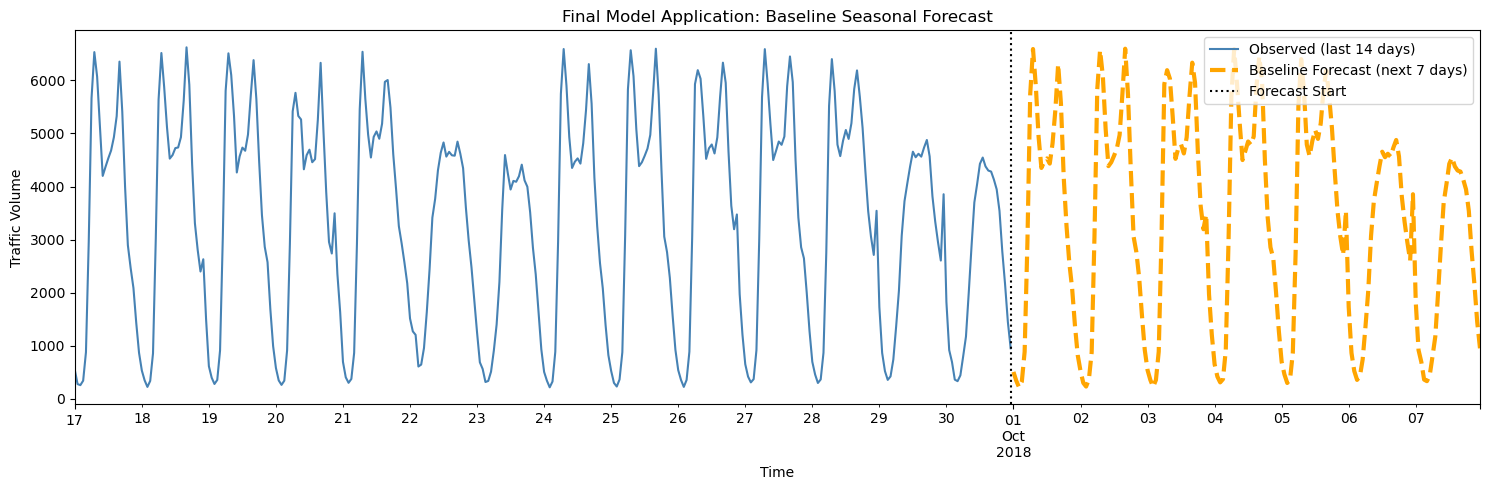

In [45]:
# Plot recent history + future forecast
plt.figure(figsize=(15, 5))

# Last 14 days of observed data
df["traffic_volume"].iloc[-336:].plot(
    label="Observed (last 14 days)",
    color="steelblue"
)

# Future 7-day forecast
y_baseline_forecast.plot(
    label="Baseline Forecast (next 7 days)",
    linestyle="--",
    color="orange",
    linewidth=3
)

# Vertical line to mark forecast start
plt.axvline(
    x=y.index.max(),
    color="black",
    linestyle=":",
    label="Forecast Start"
)

plt.title("Final Model Application: Baseline Seasonal Forecast")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.tight_layout()
plt.show()

### Observed behavior:

- Daily seasonality preserved:
  Hourly peaks and troughs repeat at the same times each day.

- Weekly structure preserve:
  Weekday vs. weekend differences follow the same pattern as the prior week.

- No artificial trend introduced:
  Forecast values remain within the recent historical range with no upward or downward drift.

- Variance consistent with history:
  Peak amplitudes and low-traffic periods match recent observations without attenuation.

### Implication:

- Short-term traffic volume is dominated by stable seasonal repetition.

- For a 7-day horizon, explicit seasonal reuse provides forecasts comparable to or better than parameterized models.

- This confirms that predictability comes from seasonality rather than model complexity.

In [46]:
# Save forecast output
forecast_df = pd.DataFrame({
    "datetime": y_baseline_forecast.index,
    "forecast_traffic_volume": y_baseline_forecast.values
})

forecast_df.to_csv("baseline_7day_forecast.csv", index=False)

## Step 10.3 — Business Recommendations

### Recommendation 1: Use Seasonal Baseline Forecasting for Short-Term Traffic Planning

What to do:

- Adopt the seasonal naive baseline (same hour, one week ago) as the default short-term forecasting method for hourly traffic volume (up to 7 days).

Why?

- The baseline model achieved the lowest RMSE among all tested models.

- It accurately reproduces:

  1. Daily commute peaks

  2. Night-time low traffic

  3. Weekday vs. weekend differences

  4. More complex models (SARIMA, SARIMAX) did not improve predictive accuracy.

Business impact: 

- Reliable short-term forecasts with:

  1. Minimal computational cost

  2. No model retraining overhead

  3. High transparency for stakeholders

### Recommendation 2: Schedule Resources Around Predictable Peak Hours

What to do:

- Align staffing, traffic control, and congestion mitigation efforts with:

  1. Morning commute peaks

  2. Evening commute peaks

  3. Higher weekday traffic volumes

Why?

- The forecast shows that peak timing and magnitude are highly stable.

- Peaks repeat at consistent hours across days.

Business impact:

- Better allocation of personnel and infrastructure

- Reduced congestion risk during known high-demand periods

- Improved operational efficiency without complex analytics

### Recommendation 3: Use Weather and Holidays as Monitoring Signals, Not Core Forecast Drivers

What to do:

- Continue tracking weather and holidays as contextual indicators, not primary forecast inputs.

- Trigger manual review or alerts during:

  1. Severe weather events

  2. Major holidays

Why?

- EDA showed weather and holidays affect traffic, but:

- Their impact is secondary to strong seasonality

- They do not consistently improve forecast accuracy when modeled statistically

Business impact:

- Avoid unnecessary model complexity

- Focus modeling effort where it provides real value

- Maintain flexibility to respond to exceptional events